In [23]:
"""
Machine Learning for Engineering Sciences
Final Project Code
Author: Eli Borrin with Thomas Bausman
"""
#%% 
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, roc_auc_score

#%% Loading Data

# Clinical 
clinical = pd.read_csv("sample.group",
                 sep="\t",
                 header=0)
clinical = clinical.iloc[:,[0,1]]
# print(clinical)

# Species Data
species = pd.read_csv("mpa4_species.profile",
                 sep="\t",
                 header=0)
#print(species)
species = species.T

# Make the first row after transposition the header
species.columns = species.iloc[0]
species = species.drop(species.index[0])

# Reset index and make it the first column
species = species.reset_index()

# Rename the index column to something meaningful (e.g. 'PatientID')
species = species.rename(columns={'index': 'ID'})

In [24]:
#%% Data Pre-Processing 

def encode_control_disease(clinical, label='Group'):
    # Convert to string first (if numeric or mixed)
    clinical[label] = clinical[label].astype(str).str.strip()

    # Map control/disease encoding robustly
    clinical[label] = clinical[label].map({
        'Control': 0,
        'Disease': 1,
        '0': 0,
        '1': 1
    })

    # Drop any rows that didn’t match
    clinical = clinical.dropna(subset=[label])

    # Rename ID column if needed
    clinical = clinical.rename(columns={'Sample': 'ID'})

    # Make sure label is integer type
    clinical[label] = clinical[label].astype(int)
    return clinical


# Test/Training data function
def split_dataframe(df, test_size = 0.1):
    """
    Split a df into training and test subsets.

    Parameters:
        df (pd.DataFrame): The DataFrame to split.
        test_size (float): The proportion of the DataFrame to include in the test set 
                           (e.g., 0.2 means 20% test data).

    Returns:
        train_df (pd.DataFrame): The training subset of the DataFrame.
        test_df (pd.DataFrame): The test subset of the DataFrame.
    """
    # Validate inputs
    if not 0 < test_size < 1:
        raise ValueError("test_size must be a decimal between 0 and 1.")
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame.")

    # Randomly shuffle the dataframe
    shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Calculate the split index
    test_count = int(len(df) * test_size)

    # Split the DataFrame
    test_df = shuffled_df.iloc[:test_count]
    train_df = shuffled_df.iloc[test_count:]

    return train_df, test_df


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

def knn_predict_disease(clinical_train: pd.DataFrame,
                        clinical_test: pd.DataFrame,
                        id_col: str,
                        label_col: str,
                        species: pd.DataFrame = species,
                        k: int = 5):
    """
    Train and evaluate a KNN model to predict disease status based on microbiome data.

    Parameters
    ----------
    clinical_train : pd.DataFrame
        Training subset of clinical data (Control=0, Disease=1).
    clinical_test : pd.DataFrame
        Test subset of clinical data (Control=0, Disease=1).
    species : pd.DataFrame
        DataFrame of microbiome species abundances per patient.
    id_col : str
        Column name for patient ID present in both dataframes.
    label_col : str
        Column name for encoded class label in clinical data.
    k : int, optional
        Number of neighbors for KNN (default = 5).

    Returns
    -------
    model : KNeighborsClassifier
        Trained KNN model.
    y_pred : np.ndarray
        Predicted labels for the test set.
    """
    # --- Merge microbiome species features with clinical labels ---
    train_df = clinical_train.merge(species, on=id_col)
    test_df = clinical_test.merge(species, on=id_col)

    # --- Separate features (X) and labels (y) ---
    X_train = train_df.drop(columns=[id_col, label_col])
    y_train = train_df[label_col]
    X_test = test_df.drop(columns=[id_col, label_col])
    y_test = test_df[label_col]

    # --- Initialize and train model ---
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # --- Predict on test set ---
    y_pred = knn.predict(X_test)

    # --- Evaluate performance ---
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ KNN (k={k}) Accuracy: {acc:.3f}\n")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return knn, y_pred


In [26]:
print("NaN count in y_train:", clinical_train['Group'].isna().sum())
print("Unique values in y_train:", clinical_train['Group'].unique())

print(clinical_train[clinical_train['Group'].isna()])


NaN count in y_train: 0
Unique values in y_train: [1 0]
Empty DataFrame
Columns: [ID, Group]
Index: []


In [27]:
# Doing the split:
clinical_encoded = encode_control_disease(clinical)

# Split Clinical
clinical_train, clinical_test = split_dataframe(clinical_encoded)


model, preds = knn_predict_disease(
    clinical_train=clinical_train,
    clinical_test=clinical_test,
    species= species,  # whichever taxonomic level
    id_col='ID',
    label_col='Group',
    k=7
)


✅ KNN (k=7) Accuracy: 0.587

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.53      0.52       276
           1       0.65      0.63      0.64       385

    accuracy                           0.59       661
   macro avg       0.58      0.58      0.58       661
weighted avg       0.59      0.59      0.59       661

Confusion Matrix:
 [[145 131]
 [142 243]]


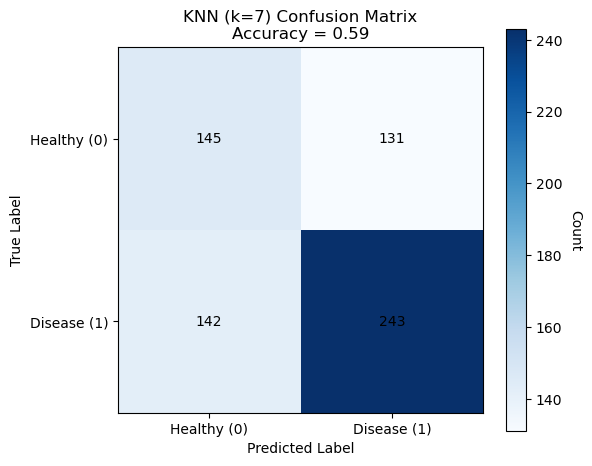

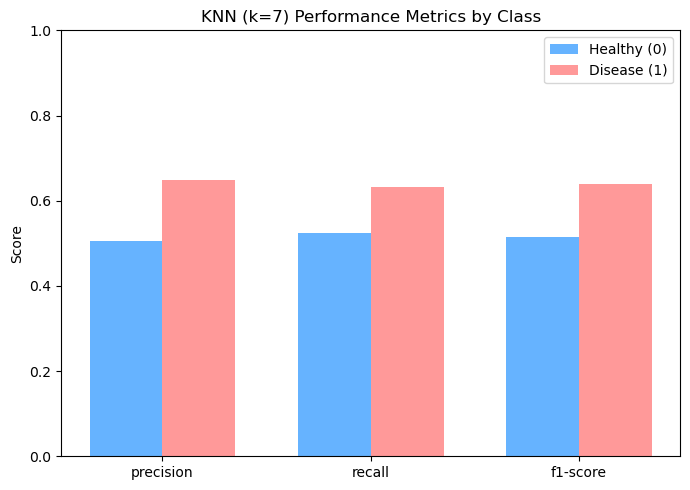

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Confusion Matrix ---
cm = confusion_matrix(clinical_test['Group'], preds)
labels = ['Healthy (0)', 'Disease (1)']

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

# Label axes
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'KNN (k=7) Confusion Matrix\nAccuracy = {accuracy_score(clinical_test["Group"], preds):.2f}')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Loop over data to label each cell
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

# --- Classification Metrics ---
report = classification_report(clinical_test['Group'], preds, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
x = np.arange(len(metrics))
width = 0.35

healthy_vals = [report['0'][m] for m in metrics]
disease_vals = [report['1'][m] for m in metrics]

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(x - width/2, healthy_vals, width, label='Healthy (0)', color='#66b3ff')
ax.bar(x + width/2, disease_vals, width, label='Disease (1)', color='#ff9999')

ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title('KNN (k=7) Performance Metrics by Class')
ax.legend()
plt.tight_layout()
plt.show()
